<a href="https://colab.research.google.com/github/sthitaprajnadas/gcp-aiml-works/blob/main/trans_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import sklearn

In [4]:
df = pd.read_excel('test_transactions0.1.xls','vivid_transactions') # load the input data

In [5]:
df.head(5)

,Date,Amount,Merchant,Category,Description
0,2025-03-16,80814.70,UNICEF,Charity,Donated INR 80814.7 via UNICEF on 16-Mar-2025...
1,2025-03-16,61816.17,Bharat Petroleum,Fuel,Filled up at Bharat Petroleum on 16-Mar-2025 i...
2,2025-03-16,110825.48,HDFC ATM,Cash Withdrawal,"Withdrawn INR 110825.48 from HDFC ATM ATM, Hy..."
3,2025-03-16,87042.87,Nature‚Äôs Basket,Groceries,A substantial shopping haul from Nature‚Äôs Ba...
4,2025-03-16,16158.42,GenericMerchant,Miscellaneous,Paid INR 16158.42 for a variety of small misc...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5000 non-null   datetime64[ns]
 1   Amount       5000 non-null   float64       
 2   Merchant     5000 non-null   object        
 3   Category     5000 non-null   object        
 4   Description  5000 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 195.4+ KB


In [7]:
df.columns = df.columns.str.lower()
str_cols = df.select_dtypes(include='object').columns
df[str_cols] =  df[str_cols].apply(lambda x: x.str.strip().str.lower().str.replace(r'[^A-Za-z0-9 ]+','',regex=True)) # Apply cleaning on description column by stripping off unwanted spaces,lowering it and removing special characters



In [15]:
df.head(10)

,date,amount,merchant,category,description
0,2025-03-16,80814.70,unicef,charity,donated inr 808147 via unicef on 16mar2025 su...
1,2025-03-16,61816.17,bharat petroleum,fuel,filled up at bharat petroleum on 16mar2025 in ...
2,2025-03-16,110825.48,hdfc atm,cash withdrawal,withdrawn inr 11082548 from hdfc atm atm hyde...
3,2025-03-16,87042.87,natures basket,groceries,a substantial shopping haul from natures baske...
4,2025-03-16,16158.42,genericmerchant,miscellaneous,paid inr 1615842 for a variety of small misce...
5,2025-03-16,125937.53,airtel,utilities,internet bill paid to airtel on 16mar2025 inr...
6,2025-03-16,40891.46,accenture,salary,monthly salary of inr 4089146 transferred fro...
7,2025-03-16,48253.87,ajio,shopping,a big sale shopping day at ajio on 16mar2025 w...
8,2025-03-16,44687.91,icici direct,investment,equity shares purchased from icici direct on 1...
9,2025-03-16,61057.61,medplus,healthcare,hospital fee of inr 6105761 for emergency ser...


## **EDA**

In [8]:
df.isna().sum()
category_counts = df['category'].value_counts()
print(category_counts)
category_percent = df['category'].value_counts(normalize=True) * 100
print(category_percent)

category
investment         381
dining             342
insurance          323
groceries          322
healthcare         321
miscellaneous      317
education          317
cash withdrawal    315
charity            313
travel             313
entertainment      305
salary             302
fuel               298
taxes              293
utilities          278
shopping           260
Name: count, dtype: int64
category
investment         7.62
dining             6.84
insurance          6.46
groceries          6.44
healthcare         6.42
miscellaneous      6.34
education          6.34
cash withdrawal    6.30
charity            6.26
travel             6.26
entertainment      6.10
salary             6.04
fuel               5.96
taxes              5.86
utilities          5.56
shopping           5.20
Name: proportion, dtype: float64


<Figure size 1500x800 with 0 Axes>

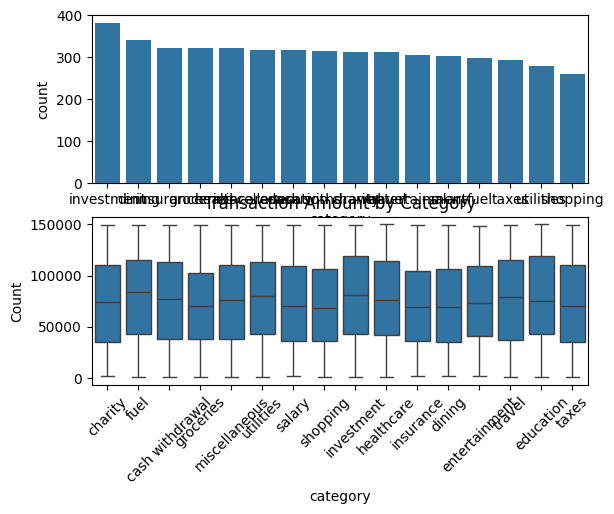

In [9]:
plt.figure(figsize=(15,8))

fig, (ax1, ax2) = plt.subplots(2)
sns.countplot(data=df, x='category', order=category_counts.index , ax=ax1)
plt.xticks(rotation=45)
plt.title('Transaction Categories Distribution')
plt.ylabel('Count')


sns.boxplot(x='category', y='amount', data=df, ax=ax2)
plt.title('Transaction Amount by Category')
plt.show()

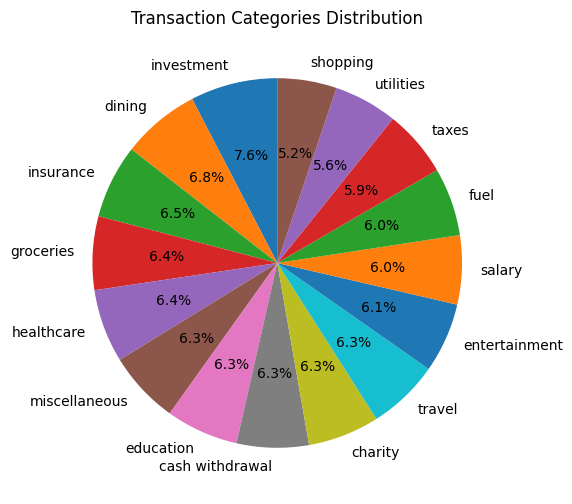

In [10]:
category_counts.plot.pie(autopct='%1.1f%%', figsize=(6,6), startangle=90)
plt.title('Transaction Categories Distribution')
plt.ylabel('')
plt.show()

In [13]:
!pip install catboost catboost[cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


## **Supervised and Unsupervised Training**


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.width', 500)
import joblib



In [92]:
X = df[['amount', 'merchant', 'description']]
y = df['category']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42,shuffle=True
)


# Define column types
numeric_features = ['amount']
categorical_features = ['merchant']
text_features = 'description'


# Define models
models = {
    #'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    #'LightGBM': LGBMClassifier(),
    #'LogisticRegression': LogisticRegression(max_iter=50, multi_class='multinomial'),
    'KNNclassifier' : KNeighborsClassifier(n_neighbors=3)

}

# Loop through models
results = []

for name, model in models.items():
    model_filename = f"{name.lower().replace(' ', '_')}_pipeline.pkl"

    if name.lower() == "knnclassifier":
        # Preprocessing with standardscaler for numeric column Amount
        preprocessor = ColumnTransformer(
            transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('text', TfidfVectorizer(max_features=200, ngram_range=(1,2)), text_features)
        ])

    else:
        # Preprocessing with standardscaler not applied for numeric column
        preprocessor = ColumnTransformer(
            transformers=[
            #('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('text', TfidfVectorizer(max_features=200, ngram_range=(1,2)), text_features)
        ])



    if os.path.exists(model_filename):
        clf = joblib.load(model_filename)
    else:
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
        clf.fit(X_train, y_train)
        joblib.dump(clf, model_filename)
        print(f"Model saved as: {model_filename}")

    y_pred = clf.predict(X_test)

# --- Concatenate features + actual + predicted and displaying the test data---

    if isinstance(y_test, np.ndarray):
        y_test_series = pd.Series(y_test, index=X_test.index, name='Actual')
    else:
        y_test_series = y_test.copy()
        y_test_series.name = 'Actual'

    # --- Make predicted labels as a Series with the same index ---
    if isinstance(y_pred, np.ndarray):
        y_pred_series = pd.Series(y_pred, index=X_test.index, name='Predicted')
    else:
        y_pred_series = y_pred.copy()
        y_pred_series.name = 'Predicted'


    test_with_predicted_df = pd.concat([X_test.reset_index(drop=True),
                          y_test_series.reset_index(drop=True),
                          y_pred_series.reset_index(drop=True)], axis=1)

    # Show first 10 rows
    print(f"\nTest Actual and prediction with model : {name}")
    print(test_with_predicted_df.head(10))

# Accumulate  detailed scores for all models

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })

# Display Scores
print(f"\nFinal scores for all models :\n")

results_df = pd.DataFrame(results)
print(results_df)



Test Actual and prediction with model : KNNclassifier
      amount         merchant                                                                                                                                                                                                                               description  Actual  Predicted
0   18170.16              ola                                                                       booked a flight through ola for a trip from noida to noida on 02apr2025 the flight ticket cost  inr 1817016 ensuring a convenient and comfortable travel experience      14         14
1    2608.48         coursera                                                                                  paid  inr 260848 to coursera for an educational course subscription on 10may2025 mumbai access to a collection of courses on python and machine learning       3          3
2   47774.67           airtel                                                                   

## Predict a single record

In [93]:
import joblib
import os

mapping_df = pd.DataFrame({
    'Category': le.classes_,
    'Encoded': range(len(le.classes_))
})
print(f"\nEncoded category column mapping as below :\n")

print(mapping_df)

print(f"\nFinal scores for all models :\n")

models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    #'LightGBM': LGBMClassifier(),
    'KNNclassifier': KNeighborsClassifier(n_neighbors=3),
    #'LogisticRegression': LogisticRegression(max_iter=50, multi_class='multinomial')
}
for name, model in models.items():
    model_filename = f"{name.lower().replace(' ', '_')}_pipeline.pkl"

    if os.path.exists(model_filename):
        clf = joblib.load(model_filename)
    else:
        print(f"model (name) file not there.Pls train")

# Example new row (must have same columns as X)
    new_row = {
        'amount': 350,
        'merchant': 'Ola',
        'description': 'took a taxi ride back home '
    }

    # Convert to DataFrame (1 row)
    new_df = pd.DataFrame([new_row])

    # Predict
    predicted_category = clf.predict(new_df)
    predicted_proba = clf.predict_proba(new_df)  # if you want probabilities

    print(f"\n\nPredicted Category with model {name} :", predicted_category[0])
    print("Prediction Probabilities:", predicted_proba[0])

    predicted_category_value = le.inverse_transform(predicted_category)
    print(f"Predicted Category with model {name}:", predicted_category_value[0])




Encoded category column mapping as below :

           Category  Encoded
0   cash withdrawal        0
1           charity        1
2            dining        2
3         education        3
4     entertainment        4
5              fuel        5
6         groceries        6
7        healthcare        7
8         insurance        8
9        investment        9
10    miscellaneous       10
11           salary       11
12         shopping       12
13            taxes       13
14           travel       14
15        utilities       15

Final scores for all models :



Predicted Category with model XGBoost : 14
Prediction Probabilities: [0.0425188  0.02355899 0.04493117 0.04708445 0.0256929  0.03819002
 0.0959013  0.02253899 0.04334652 0.02764569 0.03975904 0.06645921
 0.06025093 0.04172654 0.35983428 0.02056115]
Predicted Category with model XGBoost: travel


Predicted Category with model KNNclassifier : 14
Prediction Probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Predic

## Applying a Deep Learning Model

In [138]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

import numpy as np

patience = 3  # stop after 3 epochs of no improvement
best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

num_epochs = 50

df = pd.read_excel('test_transactions0.1.xls','vivid_transactions') # load the input data

#Preprocessing
df.columns = df.columns.str.lower()
str_cols = df.select_dtypes(include='object').columns
df[str_cols] =  df[str_cols].apply(lambda x: x.str.strip().str.lower().str.replace(r'[^A-Za-z0-9 ]+','',regex=True)) # Apply cleaning on description column by stripping off unwanted spaces,lowering it and removing special characters


# Features and label
X = df[['amount', 'merchant', 'description']]
y = df['category']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[['amount']])
X_test_num = scaler.transform(X_test[['amount']])

# Label encode categorical feature . Not applying One hot encode as it leads to too many features
merchant_encoder = LabelEncoder()
X_train_merchant = merchant_encoder.fit_transform(X_train['merchant']).reshape(-1,1)
X_test_merchant = merchant_encoder.transform(X_test['merchant']).reshape(-1,1)

# Tfidf for text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_desc = tfidf.fit_transform(X_train['description']).toarray()
X_test_desc = tfidf.transform(X_test['description']).toarray()

print("shape before PCA")
print(X_train_desc.shape)

svd = TruncatedSVD(n_components=300, random_state=42)
X_train_desc = svd.fit_transform(X_train_desc)
X_test_desc = svd.transform(X_test_desc)

print("shape after PCA")
print(X_train_desc.shape)


# Numeric column
X_train_amount = X_train[['amount']].to_numpy()
X_test_amount = X_test[['amount']].to_numpy()


X_train_amount_sparse = csr_matrix(X_train_amount)  # convert dense to sparse
X_train_merchant_sparse = csr_matrix(X_train_merchant)
X_train_desc_sparse = csr_matrix(X_train_desc)

X_test_amount_sparse = csr_matrix(X_test_amount)  # convert dense to sparse
X_test_merchant_sparse = csr_matrix(X_test_merchant)
X_test_desc_sparse = csr_matrix(X_test_desc)

# Concatenate all features
X_train_final = hstack([X_train_amount_sparse, X_train_merchant_sparse, X_train_desc_sparse])
X_test_final = hstack([X_test_amount_sparse, X_test_merchant_sparse, X_test_desc_sparse])




# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_final.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)





shape before PCA
(4000, 5000)
shape after PCA
(4000, 300)
torch.Size([4000, 302])
torch.Size([1000, 302])
torch.Size([4000])
torch.Size([1000])


In [139]:

# Create Dataset class
class TransactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TransactionDataset(X_train_tensor, y_train_tensor)
test_dataset = TransactionDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [140]:
# Define model
class FraudNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FraudNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)

        return x

input_dim = X_train_final.shape[1]
print(f"Number of input {input_dim}")

num_classes = len(np.unique(y))
print(f"Number of classes in target {num_classes}")
model = FraudNet(input_dim, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)


    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    # Accuracy
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, preds = torch.max(outputs, 1)
        acc = (preds == y_test_tensor).float().mean().item()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {acc:.4f}"
          f"Best Val Loss: {best_val_loss:.4f}")

    # ---- Early stopping check ----
    if val_loss < best_val_loss - 1e-4:  # tiny delta to avoid floating noise
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # save the best weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ---- Load the best model weights ----
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# ---- Final Evaluation ----
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, preds = torch.max(outputs, 1)
    acc = (preds == y_test_tensor).float().mean().item()
    print(f"Final Test Accuracy: {acc:.4f}")


Number of input 302
Number of classes in target 16
Epoch [1/50] Train Loss: 367.1097 Val Loss: 5.5343 Val Acc: 0.0630Best Val Loss: inf
Epoch [2/50] Train Loss: 5.6077 Val Loss: 5.5204 Val Acc: 0.0630Best Val Loss: 5.5343
Epoch [3/50] Train Loss: 5.5425 Val Loss: 5.5082 Val Acc: 0.0630Best Val Loss: 5.5204
Epoch [4/50] Train Loss: 5.5103 Val Loss: 5.4974 Val Acc: 0.0630Best Val Loss: 5.5082
Epoch [5/50] Train Loss: 5.5297 Val Loss: 5.4874 Val Acc: 0.0630Best Val Loss: 5.4974
Epoch [6/50] Train Loss: 5.5025 Val Loss: 5.4775 Val Acc: 0.0630Best Val Loss: 5.4874
Epoch [7/50] Train Loss: 5.4937 Val Loss: 5.4679 Val Acc: 0.0630Best Val Loss: 5.4775
Epoch [8/50] Train Loss: 5.4754 Val Loss: 5.4583 Val Acc: 0.0630Best Val Loss: 5.4679
Epoch [9/50] Train Loss: 5.4558 Val Loss: 5.4488 Val Acc: 0.0630Best Val Loss: 5.4583
Epoch [10/50] Train Loss: 5.4512 Val Loss: 5.4392 Val Acc: 0.0630Best Val Loss: 5.4488
Epoch [11/50] Train Loss: 5.4502 Val Loss: 5.4299 Val Acc: 0.0630Best Val Loss: 5.4392
Ep

In [109]:
dict(model.named_modules())

{'': FraudNet(
   (fc1): Linear(in_features=5067, out_features=512, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=512, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=16, bias=True)
   (dropout): Dropout(p=0.3, inplace=False)
 ),
 'fc1': Linear(in_features=5067, out_features=512, bias=True),
 'relu': ReLU(),
 'fc2': Linear(in_features=512, out_features=256, bias=True),
 'fc3': Linear(in_features=256, out_features=16, bias=True),
 'dropout': Dropout(p=0.3, inplace=False)}

In [145]:
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Sample data
import pandas as pd
df = pd.DataFrame({
    'amount': [100, 250, 50],
    'merchant': ['UNICEF', 'Amazon', 'Flipkart'],
    'description': ['Donation to UNICEF', 'Bought electronics', 'Ordered books'],
    'category': ['charity', 'shopping', 'shopping']
})

# ----------------------------
# 1️⃣ Encode categorical (merchant) using LabelEncoder
le_merchant = LabelEncoder()
df['merchant_enc'] = le_merchant.fit_transform(df['merchant'])

# 2️⃣ Numeric features
scaler = StandardScaler()
X_amount = scaler.fit_transform(df[['amount']])

# 3️⃣ Text features
tfidf = TfidfVectorizer(max_features=10)  # small for example
X_text = tfidf.fit_transform(df['description']).toarray()

# 4️⃣ Merchant indices as torch tensor
X_merchant = torch.tensor(df['merchant_enc'].values, dtype=torch.long)

# 5️⃣ Numeric and text as torch tensors
X_amount = torch.tensor(X_amount, dtype=torch.float32)
X_text = torch.tensor(X_text, dtype=torch.float32)

# ----------------------------
# 6️⃣ Define model with embedding for merchant
class FraudNetEmb(nn.Module):
    def __init__(self, num_merchants, embedding_dim, input_dim_numeric_text, num_classes):
        super().__init__()
        self.merchant_emb = nn.Embedding(num_merchants, embedding_dim)
        self.fc1 = nn.Linear(input_dim_numeric_text + embedding_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, X_num_text, X_merchant):
        emb = self.merchant_emb(X_merchant)
        x = torch.cat([X_num_text, emb], dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_merchants = len(le_merchant.classes_)
embedding_dim = 4
input_dim_numeric_text = X_amount.shape[1] + X_text.shape[1]
num_classes = len(df['category'].unique())

# 7️⃣ Initialize model
model = FraudNetEmb(num_merchants, embedding_dim, input_dim_numeric_text, num_classes)

# ----------------------------
# 8️⃣ Example forward pass
X_num_text = torch.cat([X_amount, X_text], dim=1)
output = model(X_num_text, X_merchant)
print(output)

pred_idx = torch.argmax(output, dim=1).numpy()  # shape (n_samples,)

le_category = LabelEncoder()
y = le_category.fit_transform(df['category'])
# Step 2: Convert index to original string category
pred_category = le_category.inverse_transform(pred_idx)

print("Predicted Categories:", pred_category)


tensor([[-0.2753, -0.1391],
        [-0.1346, -0.2494],
        [-0.3389, -0.2126]], grad_fn=<AddmmBackward0>)
Predicted Categories: ['shopping' 'charity' 'shopping']
